# Spiking Neural Network for CMS Muon Chamber Denoising

In [59]:
# import event simulation files
import GenEvents as ge
import PlotEvents as pe
import EventData as ed
import Params as ps

In [60]:
import numpy as np
import tqdm 
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import snntorch as snn
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
import snntorch.functional as SF

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Generate Dataset

In this first simplified scenario, we will simulate events taken in a 4x4 cell muon chamber. Signal events are not perfectly clean, but are contaminated by noise: the probability of finding noise in signal events is tuned by the *noise_frac* parameter. On the other hand, *bkg_frac* governs the signal to background ratio.

In [61]:
n_evt = 15000
n_evt_test = 3000
n_evt_val = 3000

evt_arr,      muon_list,      max_n      = ge.generate_noisy_evts(n_evt,      noise_frac=0.5, bkg_frac=0.3)
evt_arr_test, muon_list_test, max_n_test = ge.generate_noisy_evts(n_evt_test, noise_frac=0.5, bkg_frac=0.3)
evt_arr_val,  muon_list_val,  max_n_val  = ge.generate_noisy_evts(n_evt_val,  noise_frac=0.5, bkg_frac=0.3)

100%|██████████| 3000/3000 [00:03<00:00, 850.39it/s]


Here is an example of a clean true event (the only hits registered are due to a muon passing through the chamber)...

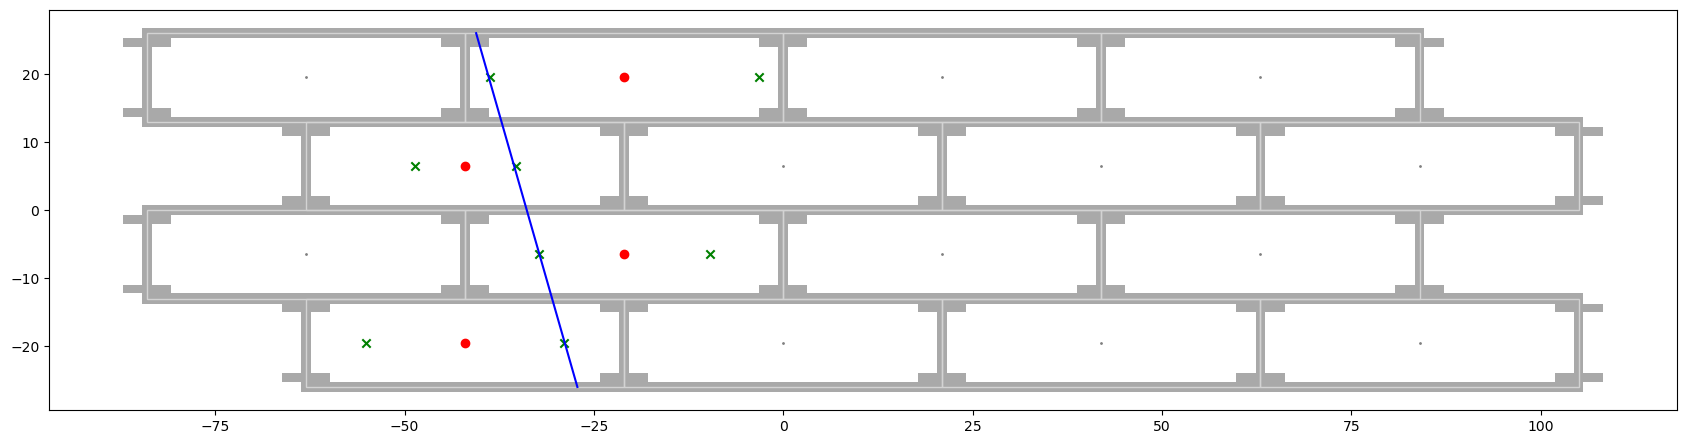

In [62]:
pe.plot_event(evt_arr[evt_arr['n_true_hits']==evt_arr['n_hits']][0])

an example of a noisy true event (a muon has actually passed through the chamber but noise has been registered as well)...

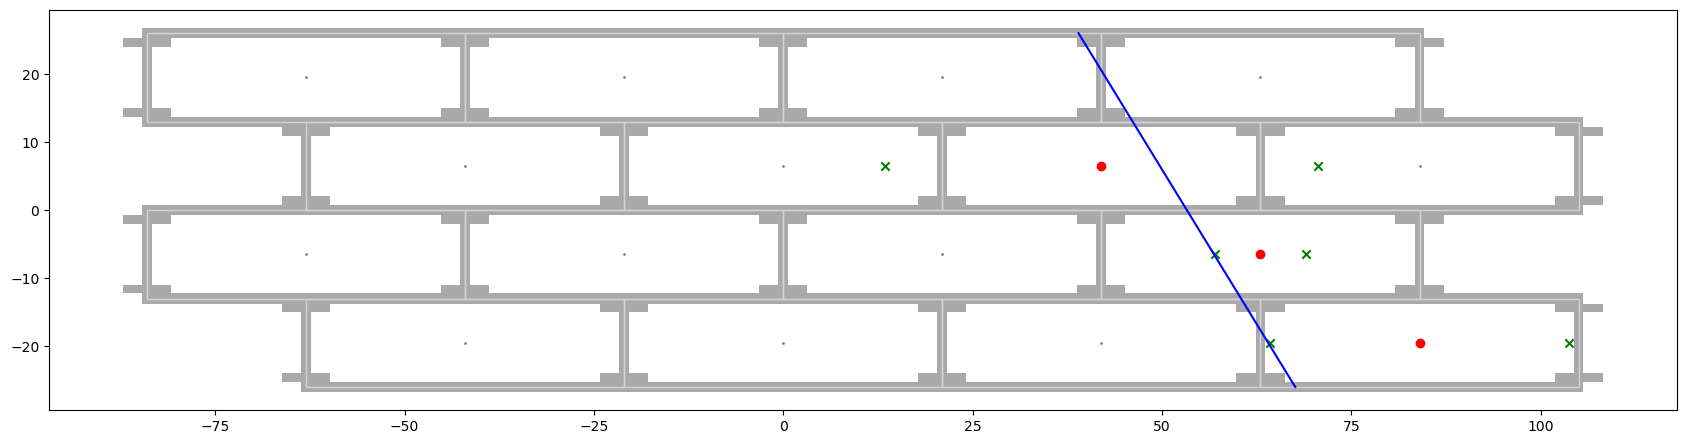

In [63]:
pe.plot_event(evt_arr[(evt_arr['n_true_hits']!=evt_arr['n_hits']) &
                      (evt_arr['n_true_hits']!=0)][0])

and finally, an example of a fake event (only noise has been registered)...

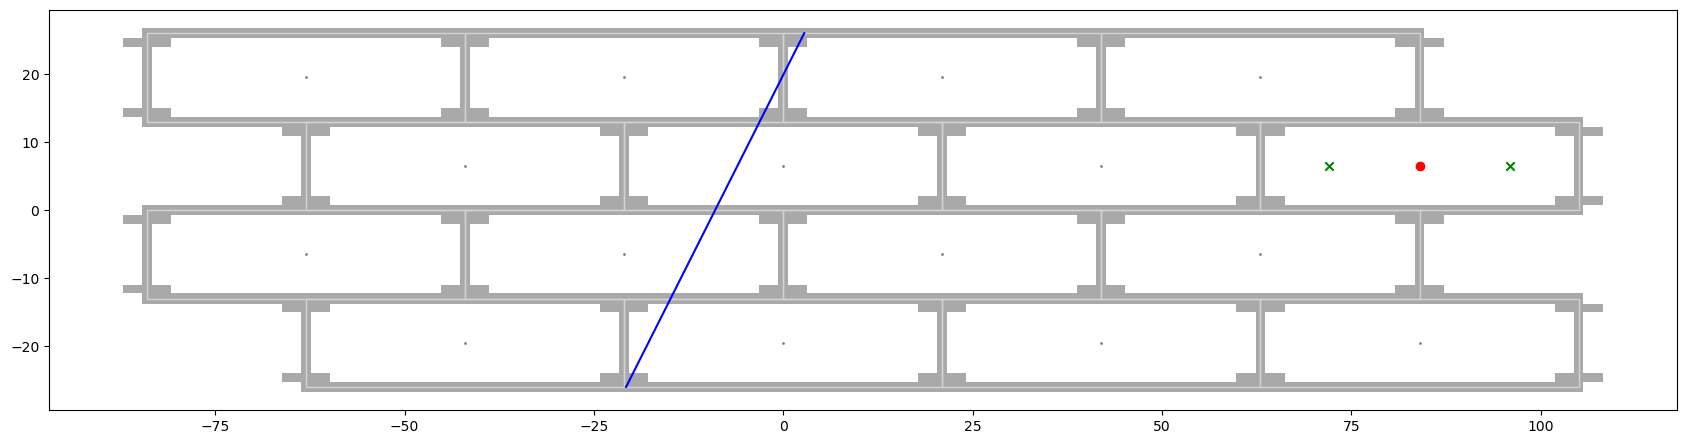

In [64]:
pe.plot_event(evt_arr[evt_arr['n_true_hits']==0][0])

To handle the generated data more easily, we will convert each event to a numpy array of fixed size, where each row will contain some information about a specific hit inside the event:

In [65]:
# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_list, size, target_dtype, features):
    padded_array = np.zeros(shape=(len(muon_list), size, len(features)), dtype=target_dtype)
    for i, muon_hits in enumerate(muon_list):
        for j, hit in enumerate(muon_hits):
            for k, f in enumerate(features):
                padded_array[i,j,k] = hit[f]  # BEWARE: implicit type conversions going on here

    return torch.tensor(padded_array)

feature_list = ['layer', 'wire_num', 'bx', 't0', 'signal']
mu_arr      = convert_to(muon_list,      size=max_n,      target_dtype=np.float32, features=feature_list)
mu_arr_test = convert_to(muon_list_test, size=max_n_test, target_dtype=np.float32, features=feature_list)
mu_arr_val  = convert_to(muon_list_val,  size=max_n_val,  target_dtype=np.float32, features=feature_list)

### Spiketrain

The last step is to create for each input event a spiketrain to feed into the SNN. \
There are many possible encodings to choose from, but as our objective is to use this network inside the online trigger system we decided on the following: each cell of the chamber will correspond to an input neuron, and each time a hit is registered we will send a spike in the neuron corresponding to the correct cell. The time is discretised in units of "BX" (bunch crossing), equal to 25 ns.

In [66]:
def custom_spikegen(data, num_step=40, batch_size=100, linearise=True):

    spike_data = torch.zeros(size=(num_step, batch_size, ps.NLAYERS,ps.NWIRES), dtype=data.dtype)
    for n_batch, evt in enumerate(data):
        for hit in evt:
            layer = int(hit[0])
            wire = int(hit[1])
            bx = int(hit[2])
            t0 = math.floor(hit[3])
            if bx != 0:
                spike_data[bx-t0+ps.bx_oot, n_batch, layer-1, wire-1] = 1
            else:
                break
    if linearise:
        spike_data = spike_data.view(num_step, batch_size, -1)
                
    return spike_data    

Let's see an example of spiketrain:

In [186]:
def train_visualization(input_train, axs, title):
    input_train = torch.transpose(input_train,0,1)
    # Plot for input_train
    axs.imshow(input_train, cmap='binary', interpolation='nearest')
    axs.set_title(title)
    axs.set_xlabel('Timestep')
    axs.set_ylabel('Neurons')


def plot_spiketrains(trains, titles):
    n = len(titles)
    fig, axs = plt.subplots(1, n, figsize=(12, 6))
    if n==1:
        train_visualization(trains, axs, titles[0])
    else:
        for i in range(n):
            train_visualization(trains[i], axs[i], titles[i])
    # Adjust layout for better spacing
    plt.tight_layout()
    # Show the plot
    plt.show()
    

tensor([[  3.0000,   3.0000, 505.0000, 500.2000,   1.0000],
        [  2.0000,   4.0000, 504.0000, 500.2000,   1.0000],
        [  3.0000,   3.0000, 507.0000, 500.2000,   0.0000],
        [  3.0000,   3.0000, 521.0000, 500.2000,   0.0000],
        [  1.0000,   4.0000, 514.0000, 500.2000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])


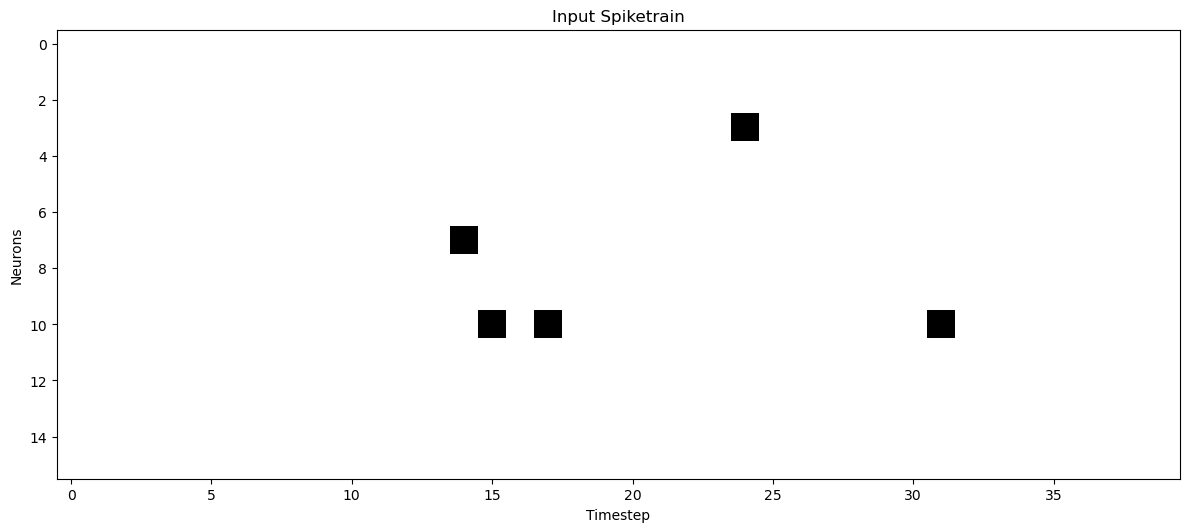

In [192]:
print(mu_arr[0])
ex_spike = custom_spikegen(mu_arr[:1,], 40, 2, True)
plot_spiketrains(ex_spike[:,0,:], ['Input Spiketrain',])

### Targets

Depending on the type of classification we want, we need to define different types of targets for the network to learn.

If we simply want to classify each event in signal/background, the target will be an array of binary values: 1 if a muon has actually passed, 0 otherwise.

In [69]:
def gen_target_chamber(muon_list):
    target = np.zeros(shape=(len(muon_list)))
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            if hit['signal'] == True:
                target[i] = 1
                break

    return torch.tensor(target, dtype=torch.long)

We can also complicate the task and try to discriminate between signal and noise for each cell inide the chamber. In this case, the target will be a 4x4 binary matrix with 1 for signal and 0 for noise or no hit. 

In [70]:
def gen_target_cell(muon_list, linearise=True):
    target = np.zeros(shape=(len(muon_list), ps.NLAYERS, ps.NWIRES))
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            layer, wire = hit['layer']-1, hit['wire_num']-1

            if hit['signal'] == True:
                target[i, layer, wire] = 1
    target = torch.tensor(target, dtype=torch.long)
    if linearise:
        target = target.view(len(muon_list), -1)

    return target

Finally, we can try to obtain an online denoising: in this case, the target will be a spiketrain similar to the one produced by the input, but where all the hits due to noise are eliminated. The generation of the actual spiketrain, though, will be handled inside the training loop.

In [71]:
def filter_noise(muon_list):
    target_list=[]
    
    for event in muon_list:
        target_event=[]
        for hit in event:
            
            if hit["signal"] == True:
                target_event.append(hit)
        
        target_list.append(target_event)
        
    return target_list

def gen_target_timing(muon_list, size, target_dtype, features):
    filtered_list = filter_noise(muon_list)
    return convert_to(filtered_list, size, target_dtype, features)
    

### Custom Dataset and Dataloader

To easily work in the PyTorch framework we will define custom datasets and dataloaders. Each item in the dataset will be a tuple containing the array of hits and the respective target.

In [72]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target, transform=None):
        self.data = list(zip(input_data, target))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        sample = self.data[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample


# Transformations

# converts to Torch tensor of desired type
def to_tensor_and_dtype(input_variable, target_dtype=torch.float32):
    
    # Convert to PyTorch tensor
    if type(input_variable) != torch.Tensor:
        input_variable = torch.tensor(input_variable)
    # Force the tensor to have the specified dtype
    tensor = input_variable.to(target_dtype)
    
    return tensor


transform = transforms.Compose([
    lambda x: (to_tensor_and_dtype(x[0], target_dtype=torch.float32), x[1])
])

## Network Definition

Now it is time to define the network proper.  \
For the architecture, we will use a fully connected net with an input neuron for each cell, a hidden layer of varying size and an output layer with a number of neurons that depends on the classification task: 2 for the whole chamber classification and $2 \cdot N_{input}$ for the cell-by-cell classification. \
Concerning the "spiking" part, we will use Leaky Integrate-and-Fire (LIF) neurons, with the decay parameter initialised at $\beta=0.8$ to match the theoretical expectation of having a decay time of ~16 BX.  

In [73]:
# Network Architecture
num_inputs = ps.NLAYERS*ps.NWIRES
num_hidden = 100
num_outputs_chamber = 2
num_outputs_cell    = 2*num_inputs

# Temporal Dynamics
num_steps = 40
beta = 0.8
threshold=1.0

In [74]:
class Net(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=threshold)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=threshold)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

### Loss Function
For the classification tasks, as the basis for the loss function we will use the *ce_count_loss* as defined by *snntorch*: 
>The spikes at each time step [num_steps x batch_size x num_outputs] are accumulated and then passed through the Cross Entropy Loss function. This criterion combines log_softmax and NLLLoss in a single function. The Cross Entropy Loss encourages the correct class to fire at all time steps, and aims to suppress incorrect classes from firing.

This loss works well when classifying the whole chamber, but needs to be tweaked when dealing with per-cell classification. For the latter, we need to define a custom loss that computes the *ce_count_loss* for each cell (corresponding to a pair of neurons) and sums the total together.

In [127]:
class Multi_loss(nn.Module):
    def __init__(self, n_classes, loss_func, timing):
        super(Multi_loss, self).__init__()
        self.n_classes = n_classes
        self.loss = loss_func
        self.timing = timing

    def forward(self, inputs, targets):
        loss = 0
        for i in range(inputs.shape[-1]//self.n_classes):
            if self.timing:
                loss += self.loss(inputs[:, :, i*self.n_classes:(i+1)*self.n_classes],
                                  targets[:, :, i])
            else:
                loss += self.loss(inputs[:, :, i*self.n_classes:(i+1)*self.n_classes],
                                  targets[:, i])
        return loss

For the online denoising, on the other hand, the simplest implementation is a MSE loss that compares the output spiketrain with the spiketrain produced by the denoised target. In order to avoid all outputs to go to zero, considering a signal as noise will be more heavily penalised.

In [164]:
class Weighted_MSE_loss(nn.Module):
    def __init__(self, weights, reduction):
        super(Weighted_MSE_loss, self).__init__()
        self.weights = weights
        self.reduction = reduction

    def forward(self, output, targets):
        diff = output - targets
        diff[diff > 0] *= self.weights[0]
        diff[diff < 0] *= self.weights[1]

        if self.reduction == 'mean':
            return torch.mean(diff ** 2)
        else:
            return torch.sum(diff ** 2)


A more refined approach consists of using the cross entropy on the membrane potentials at each time step, either using two different output neurons per cell or using BCE on a single neuron (after applying a sigmoid function to have the output inside the [0,1] range).

In [222]:
class LossFunctions:
    def _prediction_check(self, spk_out):
        device = spk_out.device

        num_steps = spk_out.size(0)
        num_outputs = spk_out.size(-1)

        return device, num_steps, num_outputs

    def _population_code(self, spk_out, num_classes, num_outputs):
        """Count up spikes sequentially from output classes."""
        if not num_classes:
            raise Exception(
                "``num_classes`` must be specified if "
                "``population_code=True``."
            )
        if num_outputs % num_classes:
            raise Exception(
                f"``num_outputs {num_outputs} must be a factor "
                f"of num_classes {num_classes}."
            )
        device = spk_out.device
        pop_code = torch.zeros(tuple([spk_out.size(1)] + [num_classes])).to(
            device
        )
        for idx in range(num_classes):
            pop_code[:, idx] = (
                spk_out[
                    :,
                    :,
                    int(num_outputs * idx / num_classes) : int(
                        num_outputs * (idx + 1) / num_classes
                    ),
                ]
                .sum(-1)
                .sum(0)
            )
        return pop_code

class ce_mem_loss_timing(LossFunctions):
    """Cross Entropy Spike Rate Loss.
    When called, the spikes at each time step are sequentially passed
    through the Cross Entropy Loss function.
    This criterion combines log_softmax and NLLLoss in a single function.
    The losses are accumulated over time steps to give the final loss.
    The Cross Entropy Loss encourages the correct class to fire at all
    time steps, and aims to suppress incorrect classes from firing.

    The Cross Entropy Rate Loss applies the Cross Entropy function at
    every time step. In contrast, the Cross Entropy Count Loss accumulates
    spikes first, and applies Cross Entropy Loss only once.


    Example::

        import snntorch.functional as SF

        loss_fn = SF.ce_rate_loss()
        loss = loss_fn(outputs, targets)

    :return: Loss
    :rtype: torch.Tensor (single element)

    """

    def __init__(self):
        self.__name__ = "ce_mem_loss_timing"

    def __call__(self, mem_out, targets):
        device, num_steps, _ = self._prediction_check(mem_out)
        log_softmax_fn = nn.LogSoftmax(dim=-1)
        loss_fn = nn.NLLLoss(reduction='sum')

        log_p_y = log_softmax_fn(mem_out)
        loss = torch.zeros((1), dtype=torch.float, device=device)

        for step in range(num_steps):
            loss += loss_fn(log_p_y[step], targets[step])

        return loss / num_steps
    
class bce_mem_loss_timing(LossFunctions):
    """Cross Entropy Spike Rate Loss.
    When called, the spikes at each time step are sequentially passed
    through the Cross Entropy Loss function.
    This criterion combines log_softmax and NLLLoss in a single function.
    The losses are accumulated over time steps to give the final loss.
    The Cross Entropy Loss encourages the correct class to fire at all
    time steps, and aims to suppress incorrect classes from firing.

    The Cross Entropy Rate Loss applies the Cross Entropy function at
    every time step. In contrast, the Cross Entropy Count Loss accumulates
    spikes first, and applies Cross Entropy Loss only once.


    Example::

        import snntorch.functional as SF

        loss_fn = SF.ce_rate_loss()
        loss = loss_fn(outputs, targets)

    :return: Loss
    :rtype: torch.Tensor (single element)

    """

    def __init__(self):
        self.__name__ = "bce_mem_loss_timing"

    def __call__(self, mem_out, targets):
        device, num_steps, _ = self._prediction_check(mem_out)
        loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
        
        loss = torch.zeros((1), dtype=torch.float, device=device)

        for step in range(num_steps):
            loss += loss_fn(mem_out[step], targets[step].float())

        return loss / num_steps

### Accuracy

In [230]:
def comp_accuracy(output, targets, type):
    total = 0
    correct = 0

    # whole chamber classification
    if type == 'chamber':
        _, predicted = output.sum(dim=0).max(1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()

    # cell-by-cell classification
    elif type == 'cell':
        batch_size = targets.size(0)
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        total = targets.numel()
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for cell-by-cell classification
    elif type == 'cell_per_evt':
        batch_size = targets.size(0)
        total = batch_size
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        for i in range(batch_size):
            correct += torch.sum((predicted[i] == targets[i]).all())

    # accuracy cell-by-cell moment-bymoment for precise timing recontruction
    elif type == 'mse_timing':
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = targets.numel()
        correct = (output == targets).sum().item()

    # accuracy on the whole event for timing reconstruction
    elif type == 'mse_timing_per_evt':
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = batch_size
        for i in range(batch_size):
            correct += torch.sum((output[:, i] == targets[:, i]).all())

    elif type == "ce_timing":
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = targets.numel()
        _, predicted = output.view(num_steps, batch_size, ps.NLAYERS*ps.NWIRES, -1).max(3)
        correct = (predicted == targets).sum().item()

    elif type == "bce_timing":
        total = targets.numel()
        sigmoid = nn.Sigmoid()
        predicted = sigmoid(output)
        predicted[predicted <  0.5] = 0
        predicted[predicted >= 0.5] = 1
        correct = (predicted == targets).sum().item()


    return total, correct

In [168]:
def accuracy_set(net, data_loader, loss_fn, accuracy_type, batch_size, timing, linearise, use_membrane):
    net.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        temp_loss = []
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss = loss_fn(output, targets)
            temp_loss.append(loss.item())

            # calculate total accuracy
            tot, corr = comp_accuracy(output, targets, accuracy_type)
            total += tot
            correct += corr

        mean_loss = np.mean(temp_loss)
        acc = correct/total
        return mean_loss, acc

### Training

In [169]:
def train_net(net, train_loader, val_loader, num_epochs, loss_fn, optimizer, accuracy_type,
              batch_size, linearise=True, timing=False, use_membrane=False):

    net.to(device)
    
    loss_hist = []
    loss_val_hist = []
    acc_val_hist = []

    iter_counter = 0

    for epoch in range(num_epochs):
        net.train()
        batch_counter = 0
        # Minibatch training loop
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss_val = loss_fn(output, targets)
        
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
        
            if iter_counter % 50 == 0:
                print("Epoch:", epoch)
                print("Batch:", batch_counter)
                print("Iteration:", iter_counter)
                print("Loss:", loss_val.item(),"\n")
        
            batch_counter += 1
            iter_counter += 1

        # Validation
        mean_loss_val, acc_val = accuracy_set(net, val_loader, loss_fn, accuracy_type,
                                              batch_size, timing, linearise, use_membrane)

        loss_val_hist.append(mean_loss_val)
        acc_val_hist.append(acc_val)
        print(f"Validation Set Loss: {mean_loss_val}")
        print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
        print("\n--------------------------------------------------\n")

    return loss_hist, loss_val_hist, acc_val_hist

## Results

### Chamber Classification

In [129]:
target      = gen_target_chamber(muon_list)
target_test = gen_target_chamber(muon_list_test)
target_val  = gen_target_chamber(muon_list_val)

15000it [00:00, 249950.58it/s]


3000it [00:00, 187636.62it/s]
3000it [00:00, 214440.03it/s]


In [112]:
train_dataset = CustomDataset(mu_arr,      target,      transform=transform)
test_dataset  = CustomDataset(mu_arr_test, target_test, transform=transform)
val_dataset   = CustomDataset(mu_arr_val,  target_val,  transform=transform)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, num_workers=nw)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=nw)

In [105]:
net = Net(num_inputs, num_hidden, num_outputs_chamber, num_steps).to(device)

In [83]:
loss_fn = SF.ce_count_loss()
accuracy_type = 'chamber'
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 5

loss_hist, loss_val_hist, acc_val_hist = train_net(net,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6931473016738892 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.4264127016067505 

Validation Set Loss: 0.4950338433186213
Validation Set Accuracy: 77.60%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 150
Loss: 0.45723626017570496 

Epoch: 1
Batch: 50
Iteration: 200
Loss: 0.503385603427887 

Epoch: 1
Batch: 100
Iteration: 250
Loss: 0.427605539560318 

Validation Set Loss: 0.3809732019901276
Validation Set Accuracy: 88.97%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 300
Loss: 0.36729544401168823 

Epoch: 2
Batch: 50
Iteration: 350
Loss: 0.204097181558609 

Epoch: 2
Batch: 100
Iteration: 400
Loss: 0.203854501247406 

Validation Set Loss: 0.198647627979517
Validation Set Accuracy: 93.20%

--------------------------------------------------

Epoch: 3
Batch: 0
Iteration: 450
Loss: 0.18705853819847107 

Epoch: 3
Batch: 50
It

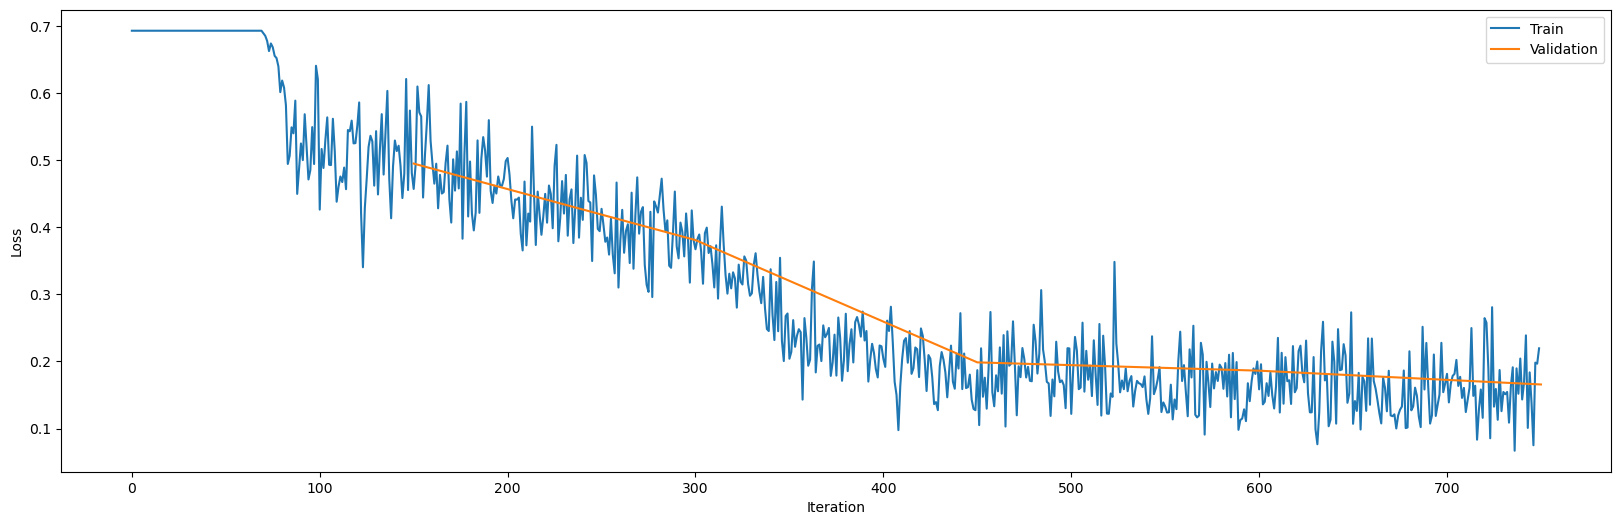

In [84]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(n_evt/batch_size, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

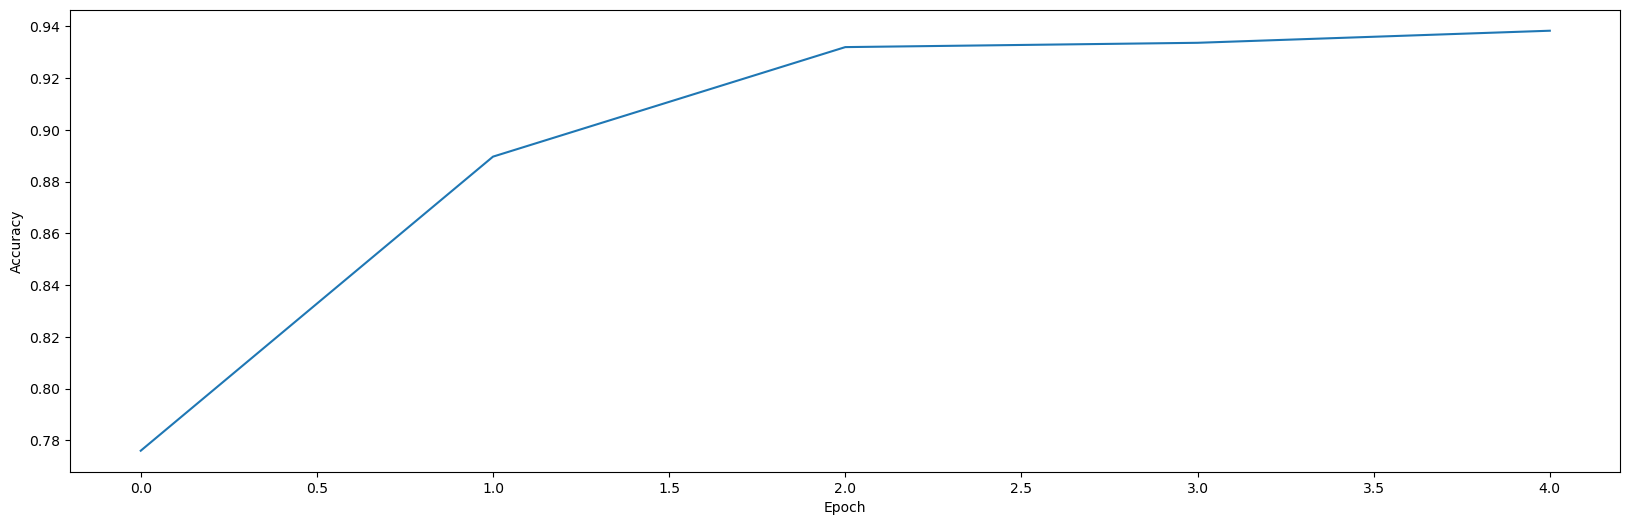

In [85]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [86]:
mean_loss_test, acc_test = accuracy_set(net, test_loader, loss_fn, 'chamber', batch_size, False, True)
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")


Test Set Loss: 0.161378742257754
Test Set Accuracy: 93.83%


In [128]:
net = Net(num_inputs, num_hidden, num_outputs_chamber, num_steps).to(device)

In [114]:
loss_fn = SF.ce_rate_loss()
accuracy_type = 'chamber'
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 5

loss_hist, loss_val_hist, acc_val_hist = train_net(net,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931475400924683 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6924477219581604 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6710835099220276 

Validation Set Loss: 0.6519942581653595
Validation Set Accuracy: 70.40%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 150
Loss: 0.6608899235725403 

Epoch: 1
Batch: 50
Iteration: 200
Loss: 0.6399642825126648 

Epoch: 1
Batch: 100
Iteration: 250
Loss: 0.6026477217674255 

Validation Set Loss: 0.6189802487691244
Validation Set Accuracy: 70.40%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 300
Loss: 0.6594507098197937 

Epoch: 2
Batch: 50
Iteration: 350
Loss: 0.5949368476867676 

Epoch: 2
Batch: 100
Iteration: 400
Loss: 0.6051127910614014 

Validation Set Loss: 0.614716515938441
Validation Set Accuracy: 70.40%

--------------------------------------------------

Epoch: 3
Batch: 0
Iteration: 450
Loss: 0.6638111472129822 

Epoch: 3
Batch: 50
I

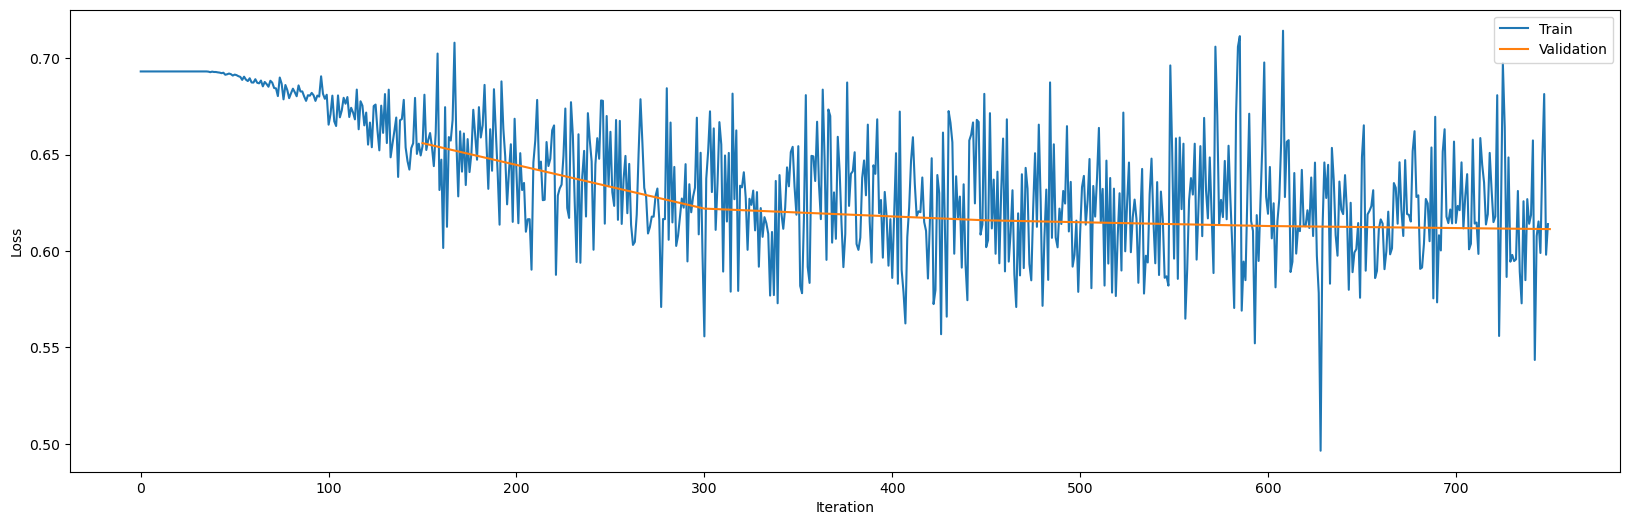

In [107]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(n_evt/batch_size, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

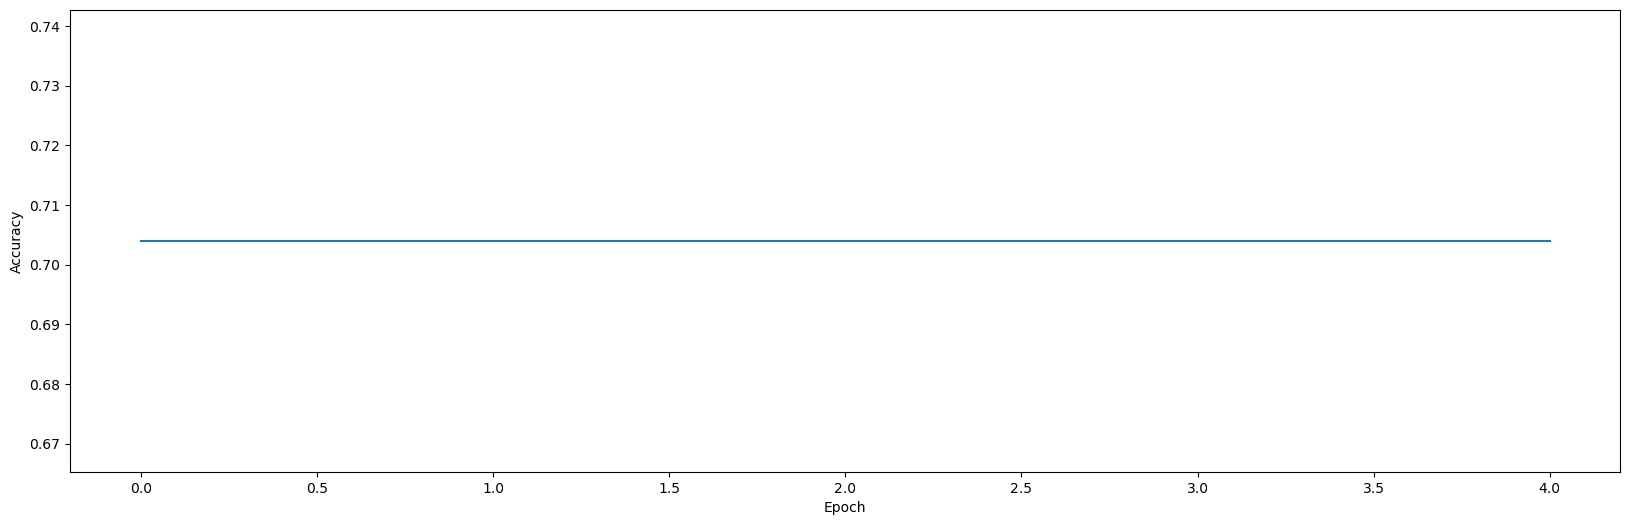

In [115]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [109]:
mean_loss_test, acc_test = accuracy_set(net, test_loader, loss_fn, 'chamber', batch_size, False, True)
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

Test Set Loss: 0.6108200212319692
Test Set Accuracy: 70.43%


### Cell-by-Cell Classification

In [130]:
target      = gen_target_cell(muon_list, True)
target_test = gen_target_cell(muon_list_test, True)
target_val  = gen_target_cell(muon_list_val, True)

15000it [00:00, 332844.29it/s]
3000it [00:00, 260677.69it/s]
3000it [00:00, 299414.92it/s]


In [131]:
train_dataset = CustomDataset(mu_arr,      target,      transform=transform)
test_dataset  = CustomDataset(mu_arr_test, target_test, transform=transform)
val_dataset   = CustomDataset(mu_arr_val,  target_val,  transform=transform)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, num_workers=nw)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=nw)

In [132]:
net = Net(num_inputs, num_hidden, num_outputs_cell, num_steps).to(device)

In [133]:
loss_fn = Multi_loss(2, SF.ce_count_loss(), False)
accuracy_type = 'cell'
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 5

loss_hist, loss_val_hist, acc_val_hist = train_net(net,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 11.090357780456543 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 10.479589462280273 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 8.43715763092041 

Validation Set Loss: 6.386539077758789
Validation Set Accuracy: 84.09%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 150
Loss: 6.33587646484375 

Epoch: 1
Batch: 50
Iteration: 200
Loss: 5.9394145011901855 

Epoch: 1
Batch: 100
Iteration: 250
Loss: 5.443934440612793 

Validation Set Loss: 4.7097333113352455
Validation Set Accuracy: 85.49%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 300
Loss: 4.612277030944824 

Epoch: 2
Batch: 50
Iteration: 350
Loss: 3.6961355209350586 

Epoch: 2
Batch: 100
Iteration: 400
Loss: 3.131736993789673 

Validation Set Loss: 2.915247933069865
Validation Set Accuracy: 91.14%

--------------------------------------------------

Epoch: 3
Batch: 0
Iteration: 450
Loss: 2.797976493835449 

Epoch: 3
Batch: 50
Iteration:

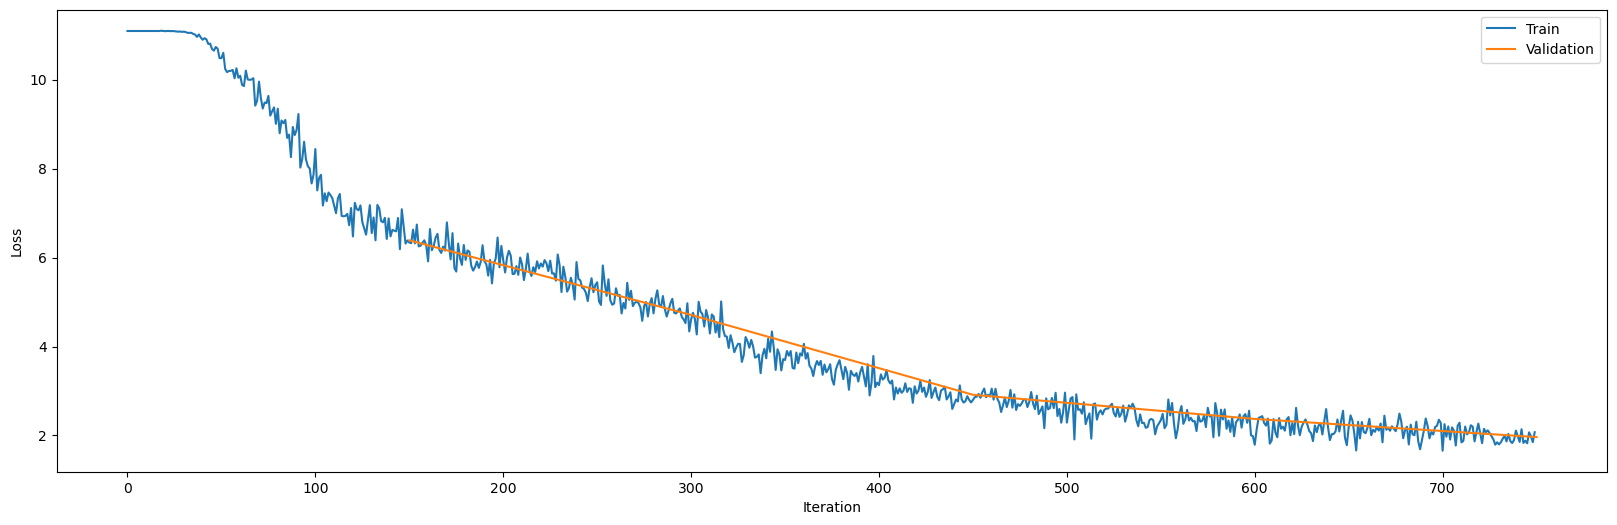

In [134]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(n_evt/batch_size, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

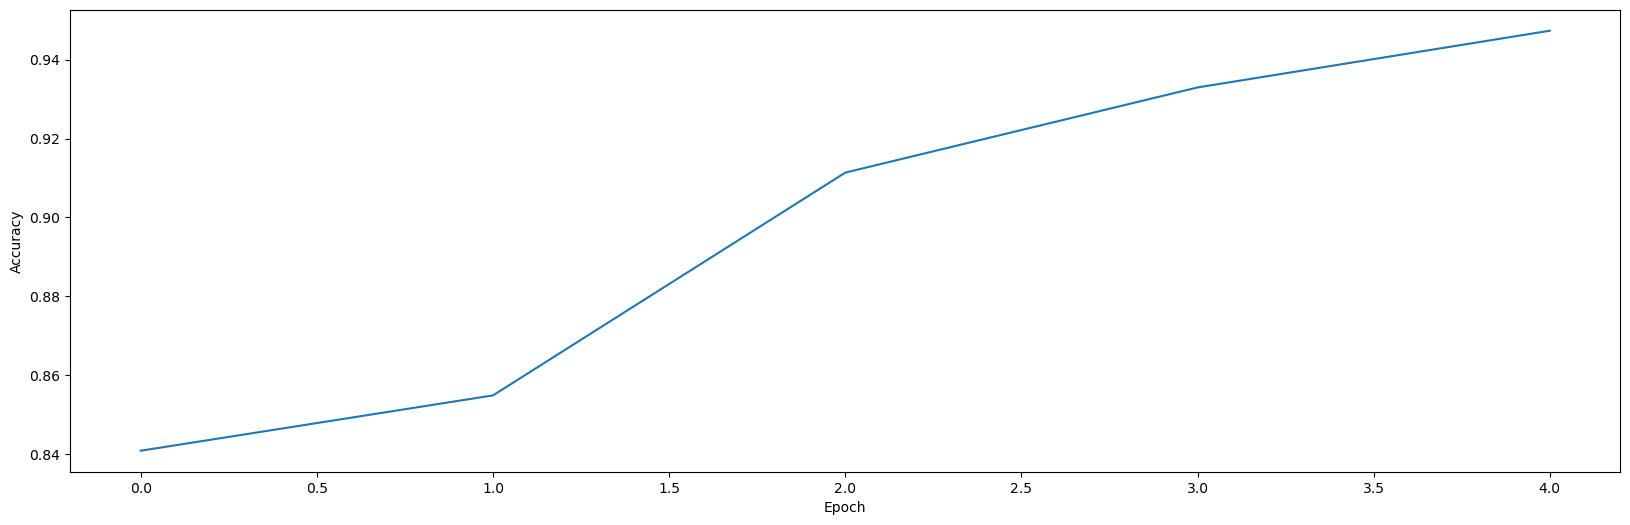

In [135]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [136]:
mean_loss_test, acc_test = accuracy_set(net, test_loader, loss_fn, 'cell', batch_size, False, True)
print("Analysing cell-by-cell:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

mean_loss_test, acc_test = accuracy_set(net, test_loader, loss_fn, 'cell_per_evt', batch_size, False, True)
print("Analysing event-per-event:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")



Analysing cell-by-cell:
Test Set Loss: 1.944291853904724
Test Set Accuracy: 94.81%
Analysing event-per-event:
Test Set Loss: 1.9442918181419373
Test Set Accuracy: 54.50%


In [119]:
net = Net(num_inputs, num_hidden, num_outputs_cell, num_steps).to(device)

In [120]:
loss_fn = Multi_loss(2, SF.ce_rate_loss(), False)
accuracy_type = 'cell'
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 5

loss_hist, loss_val_hist, acc_val_hist = train_net(net,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 11.090361595153809 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 11.0725736618042 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 10.342209815979004 

Validation Set Loss: 8.636108144124348
Validation Set Accuracy: 84.09%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 150
Loss: 8.667595863342285 

Epoch: 1
Batch: 50
Iteration: 200
Loss: 7.81249475479126 

Epoch: 1
Batch: 100
Iteration: 250
Loss: 7.942263126373291 

Validation Set Loss: 7.822334305445353
Validation Set Accuracy: 84.09%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 300
Loss: 8.000364303588867 

Epoch: 2
Batch: 50
Iteration: 350
Loss: 7.529944896697998 

Epoch: 2
Batch: 100
Iteration: 400
Loss: 7.638948917388916 

Validation Set Loss: 7.821270529429118
Validation Set Accuracy: 84.09%

--------------------------------------------------

Epoch: 3
Batch: 0
Iteration: 450
Loss: 7.871530055999756 

Epoch: 3
Batch: 50
Iteration: 50

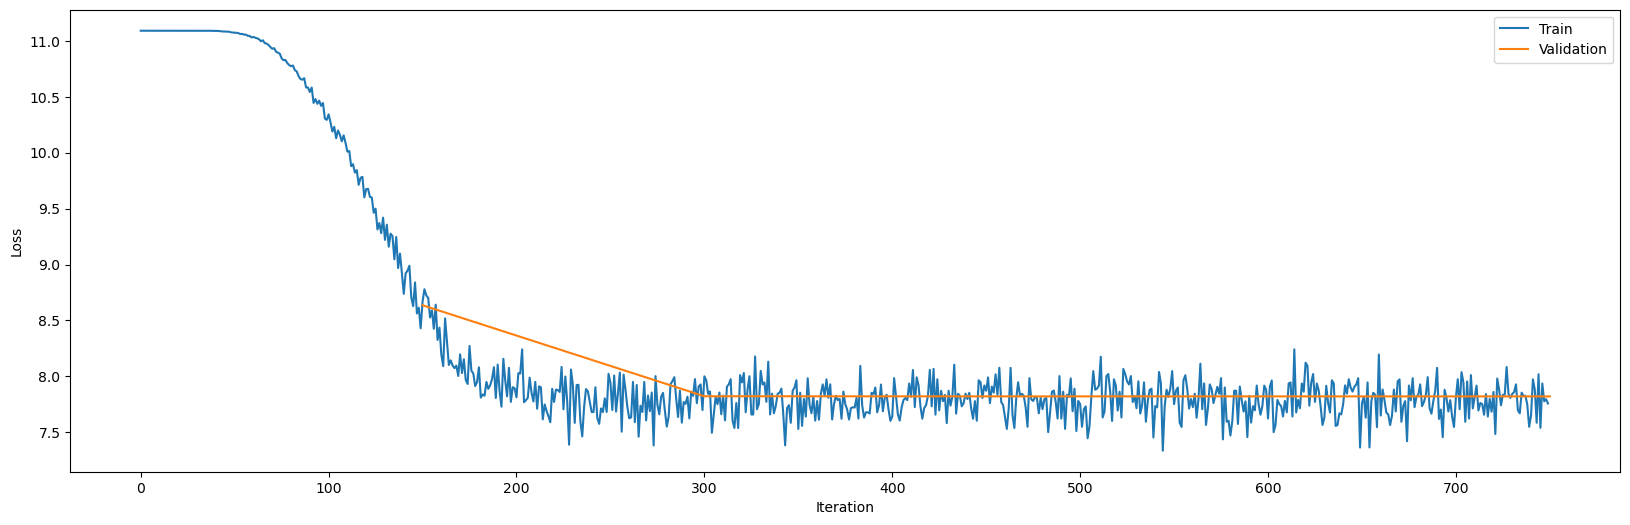

In [121]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(n_evt/batch_size, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

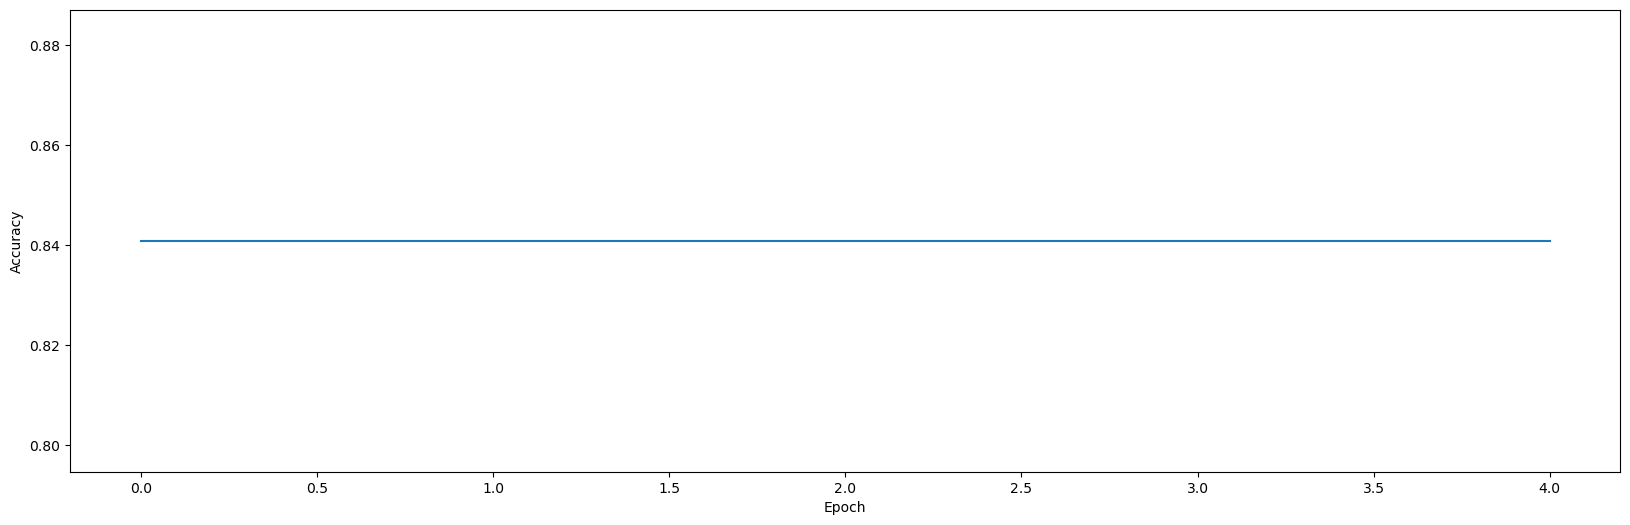

In [122]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [123]:
mean_loss_test, acc_test = accuracy_set(net, test_loader, loss_fn, 'cell', batch_size, False, True)
print("Analysing cell-by-cell:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

mean_loss_test, acc_test = accuracy_set(net, test_loader, loss_fn, 'cell_per_evt', batch_size, False, True)
print("Analysing event-per-event:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")


Analysing cell-by-cell:
Test Set Loss: 7.833561786015829
Test Set Accuracy: 84.01%
Analysing event-per-event:
Test Set Loss: 7.833561801910401
Test Set Accuracy: 29.57%


### Precise Timing

In [199]:
target      = gen_target_timing(muon_list,      size=max_n,      target_dtype=np.float32, features=feature_list)
target_test = gen_target_timing(muon_list_test, size=max_n_test, target_dtype=np.float32, features=feature_list)
target_val  = gen_target_timing(muon_list_val,  size=max_n_val,  target_dtype=np.float32, features=feature_list)

In [200]:
train_dataset = CustomDataset(mu_arr,      target,      transform=transform)
test_dataset  = CustomDataset(mu_arr_test, target_test, transform=transform)
val_dataset   = CustomDataset(mu_arr_val,  target_val,  transform=transform)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, num_workers=nw)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=nw)

In [97]:
net = Net(num_inputs, num_hidden, num_inputs, num_steps).to(device)

In [98]:
loss_fn = Weighted_MSE_loss([50,1], 'sum')
accuracy_type = 'mse_timing'
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 5

loss_hist, loss_val_hist, acc_val_hist = train_net(net,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, batch_size, True, True)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 246.0 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 256.0 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 288.0 

Validation Set Loss: 254.56666666666666
Validation Set Accuracy: 99.60%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 150
Loss: 278.0 

Epoch: 1
Batch: 50
Iteration: 200
Loss: 264.0 

Epoch: 1
Batch: 100
Iteration: 250
Loss: 233.0 

Validation Set Loss: 337.9
Validation Set Accuracy: 99.60%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 300
Loss: 228.0 

Epoch: 2
Batch: 50
Iteration: 350
Loss: 246.0 

Epoch: 2
Batch: 100
Iteration: 400
Loss: 247.0 

Validation Set Loss: 254.56666666666666
Validation Set Accuracy: 99.60%

--------------------------------------------------

Epoch: 3
Batch: 0
Iteration: 450
Loss: 287.0 

Epoch: 3
Batch: 50
Iteration: 500
Loss: 242.0 

Epoch: 3
Batch: 100
Iteration: 550
Loss: 235.0 

Validation Set Loss: 254.56666666666666
Validation Set Accuracy: 

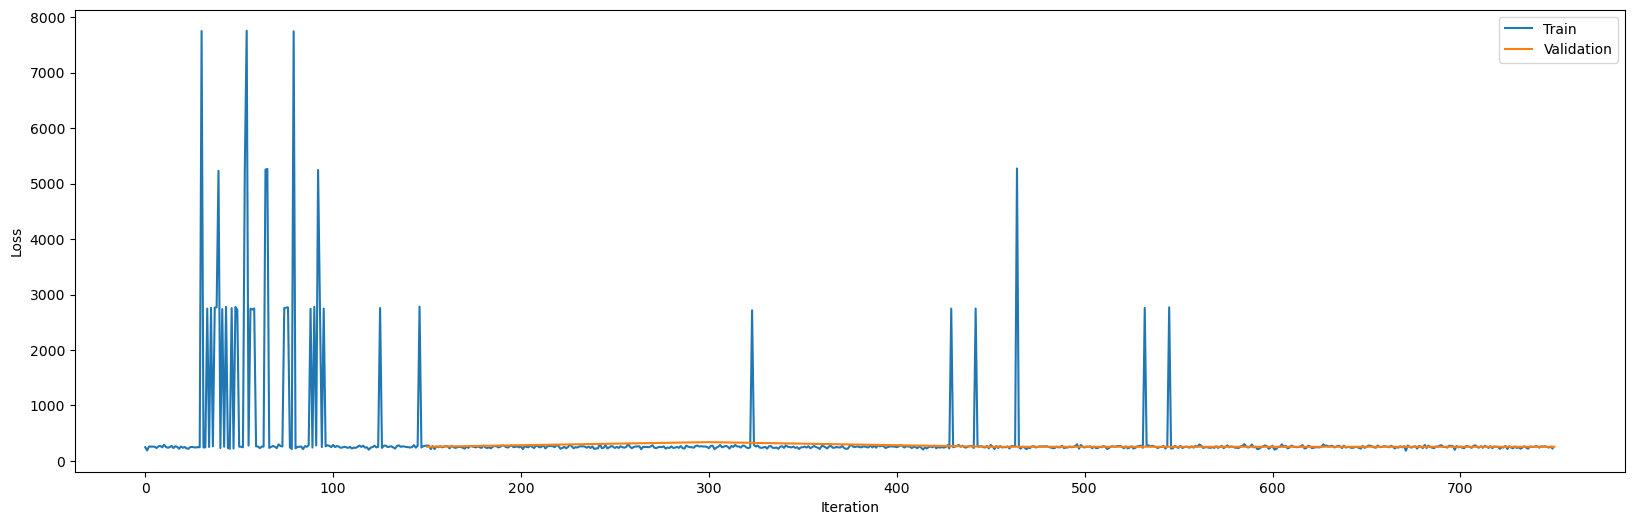

In [99]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(n_evt/batch_size, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

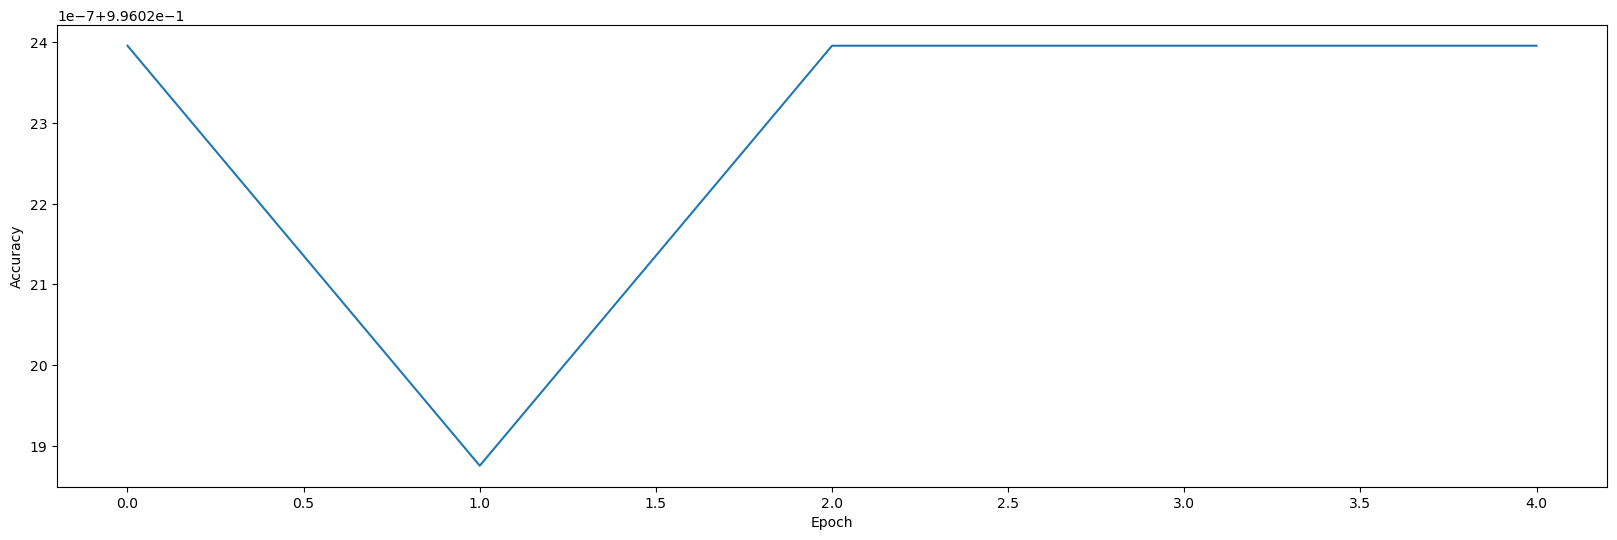

In [100]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [101]:
mean_loss_test, acc_test = accuracy_set(net, test_loader, loss_fn, 'mse_timing', batch_size, True, True)
print("Analysing cell-by-cell and moment-by-moment:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

mean_loss_test, acc_test = accuracy_set(net, test_loader, loss_fn, 'mse_timing_per_evt', batch_size, True, True)
print("Analysing event-per-event:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")


Analysing cell-by-cell and moment-by-moment:
Test Set Loss: 255.86666666666667
Test Set Accuracy: 99.60%


In [170]:
net = Net(num_inputs, num_hidden, num_outputs_cell, num_steps).to(device)

In [171]:
loss_fn = Multi_loss(2, ce_mem_loss_timing(), True)
accuracy_type = 'ce_timing'
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 5

loss_hist, loss_val_hist, acc_val_hist = train_net(net,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, batch_size, True, True, True)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 10.399157524108887 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 6.867294788360596 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 3.80635142326355 

Validation Set Loss: 2.1870240926742555
Validation Set Accuracy: 98.98%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 150
Loss: 2.186739683151245 

Epoch: 1
Batch: 50
Iteration: 200
Loss: 1.6823010444641113 

Epoch: 1
Batch: 100
Iteration: 250
Loss: 1.4740915298461914 

Validation Set Loss: 1.4367717067400614
Validation Set Accuracy: 99.14%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 300
Loss: 1.4213999509811401 

Epoch: 2
Batch: 50
Iteration: 350
Loss: 1.3996429443359375 

Epoch: 2
Batch: 100
Iteration: 400
Loss: 1.2946407794952393 

Validation Set Loss: 1.1852841178576152
Validation Set Accuracy: 99.60%

--------------------------------------------------

Epoch: 3
Batch: 0
Iteration: 450
Loss: 1.177085041999817 

Epoch: 3
Batch: 50
Itera

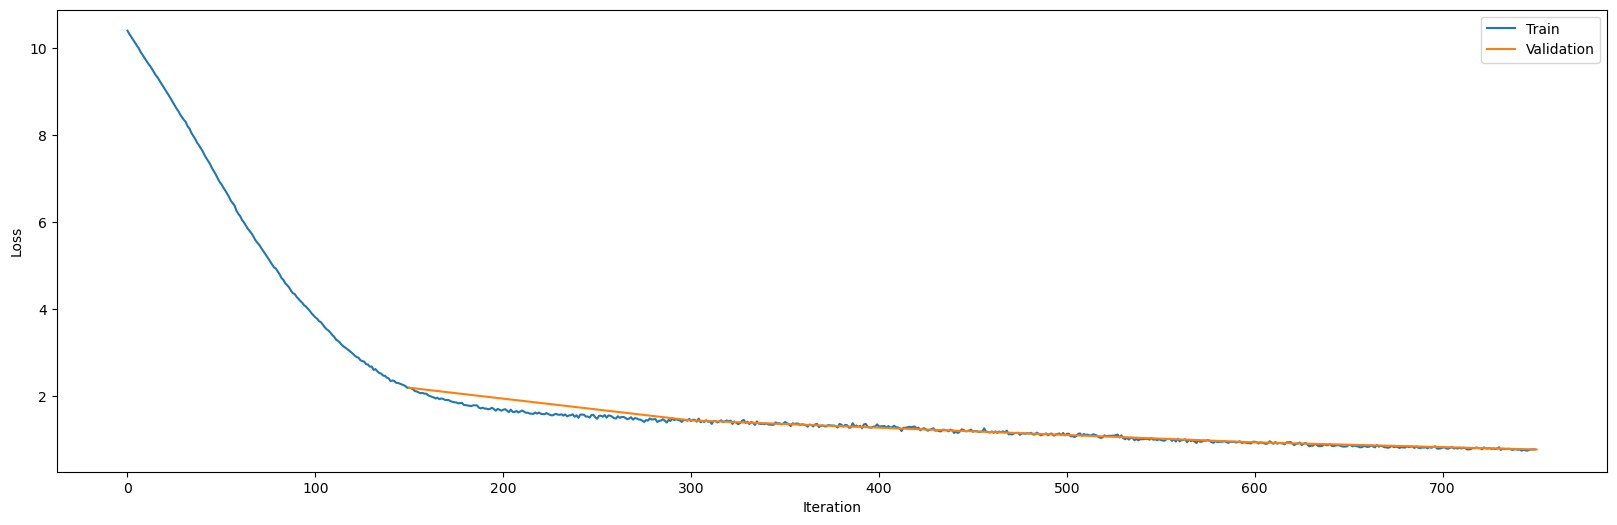

In [172]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(n_evt/batch_size, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

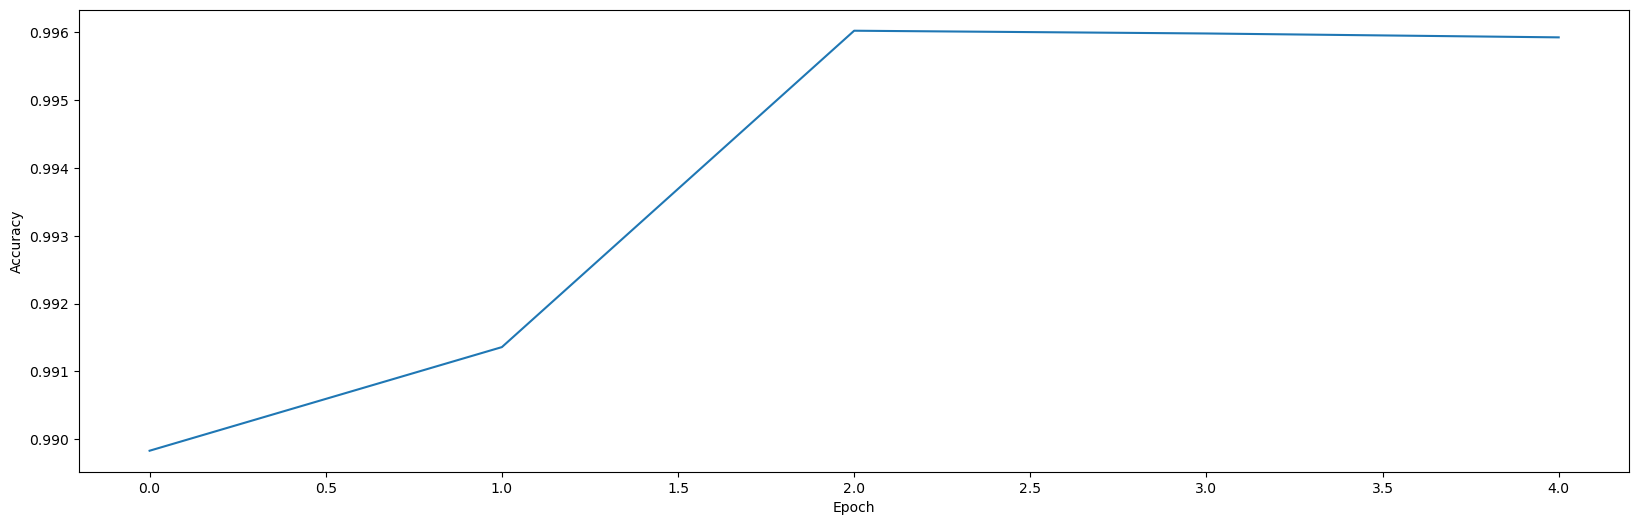

In [201]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [202]:
mean_loss_test, acc_test = accuracy_set(net, test_loader, loss_fn, 'ce_timing', batch_size, True, True, True)
print("Analysing cell-by-cell and moment-by-moment:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

Analysing cell-by-cell and moment-by-moment:
Test Set Loss: 0.7682914435863495
Test Set Accuracy: 99.59%


In [231]:
net = Net(num_inputs, num_hidden, num_inputs, num_steps).to(device)

In [232]:
loss_fn = bce_mem_loss_timing()
accuracy_type = 'bce_timing'
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 5

loss_hist, loss_val_hist, acc_val_hist = train_net(net,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, batch_size, True, True, True)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 1138.488525390625 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 942.9368286132812 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 652.884033203125 

Validation Set Loss: 356.2607777913411
Validation Set Accuracy: 96.51%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 150
Loss: 357.0570983886719 

Epoch: 1
Batch: 50
Iteration: 200
Loss: 225.2731475830078 

Epoch: 1
Batch: 100
Iteration: 250
Loss: 172.58839416503906 

Validation Set Loss: 156.90131123860678
Validation Set Accuracy: 98.21%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 300
Loss: 153.86868286132812 

Epoch: 2
Batch: 50
Iteration: 350
Loss: 148.55410766601562 

Epoch: 2
Batch: 100
Iteration: 400
Loss: 142.6460418701172 

Validation Set Loss: 134.49859720865885
Validation Set Accuracy: 99.14%

--------------------------------------------------

Epoch: 3
Batch: 0
Iteration: 450
Loss: 134.15951538085938 

Epoch: 3
Batch: 50
Iteratio

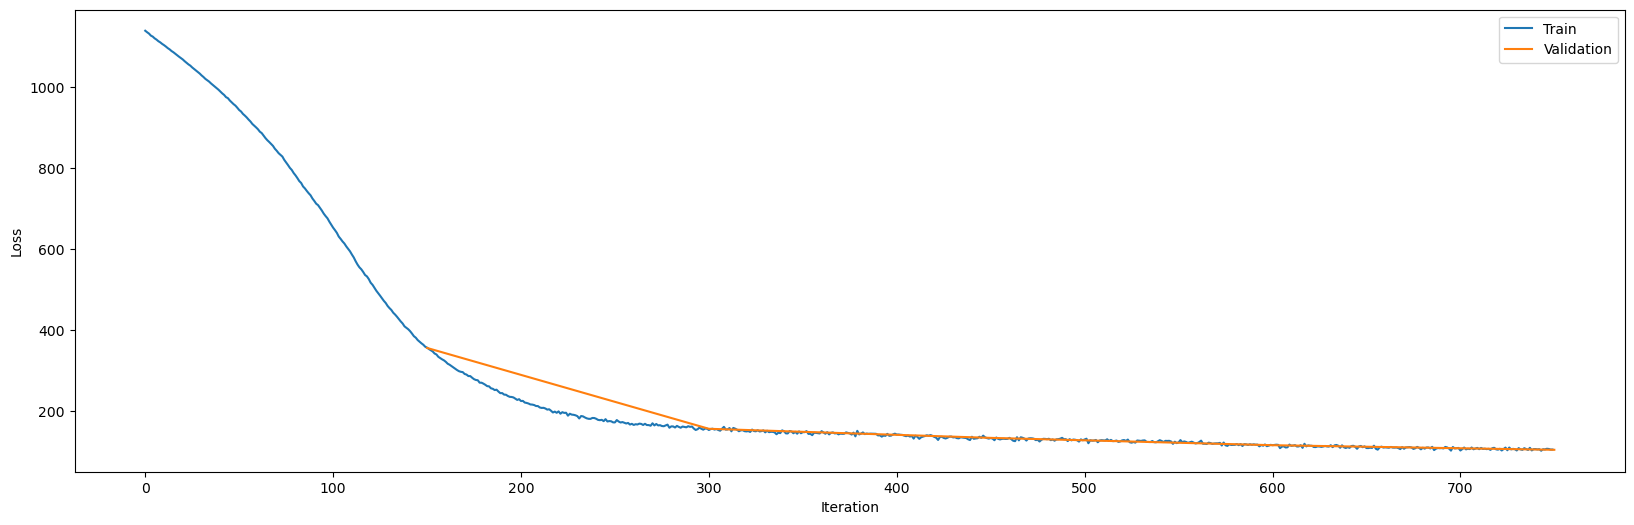

In [233]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(n_evt/batch_size, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

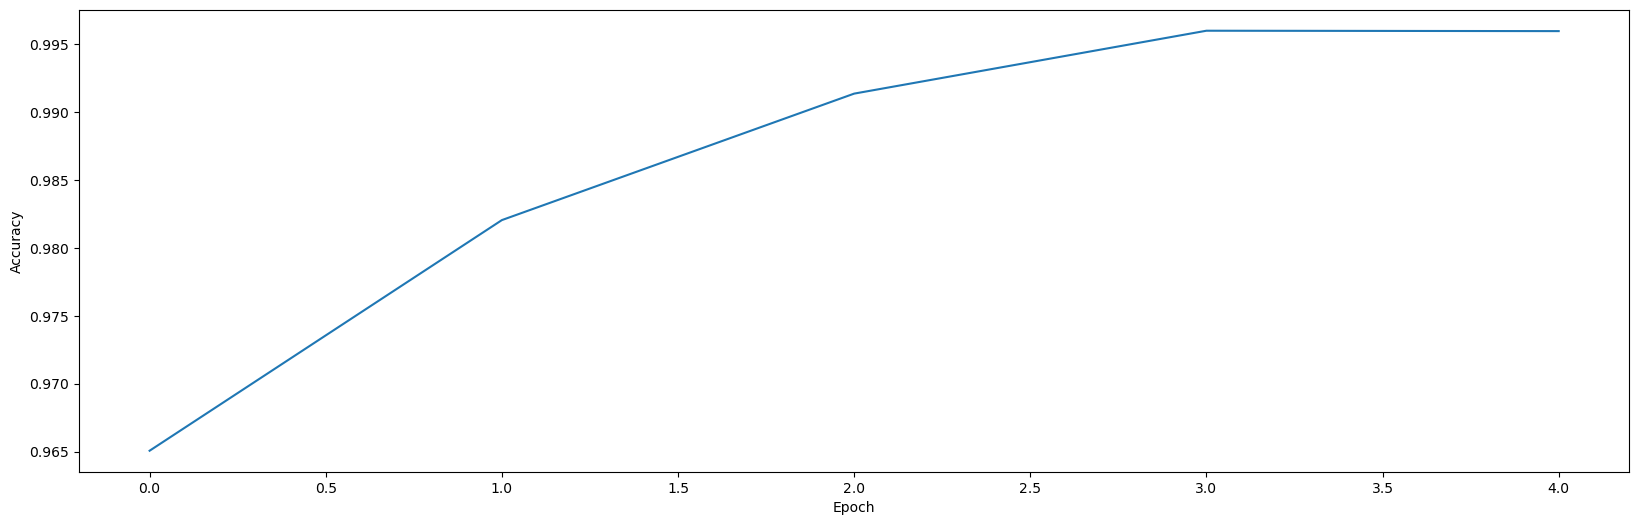

In [235]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [236]:
mean_loss_test, acc_test = accuracy_set(net, test_loader, loss_fn, 'bce_timing', batch_size, True, True, True)
print("Analysing cell-by-cell and moment-by-moment:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

Analysing cell-by-cell and moment-by-moment:
Test Set Loss: 105.27792231241862
Test Set Accuracy: 99.60%


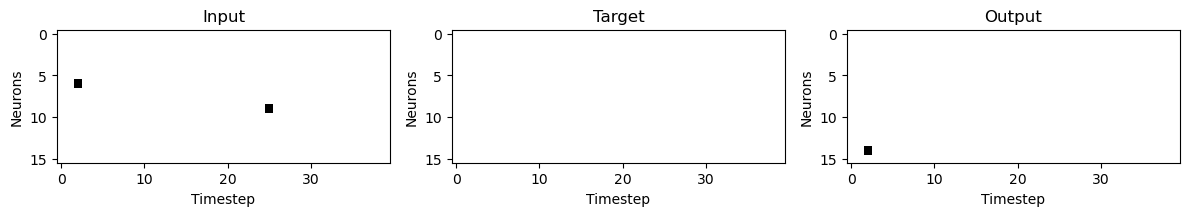

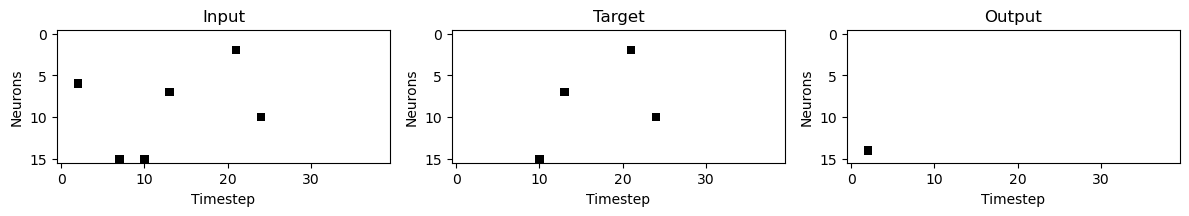

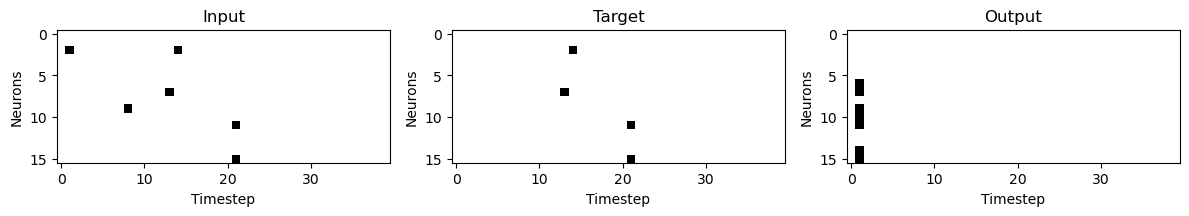

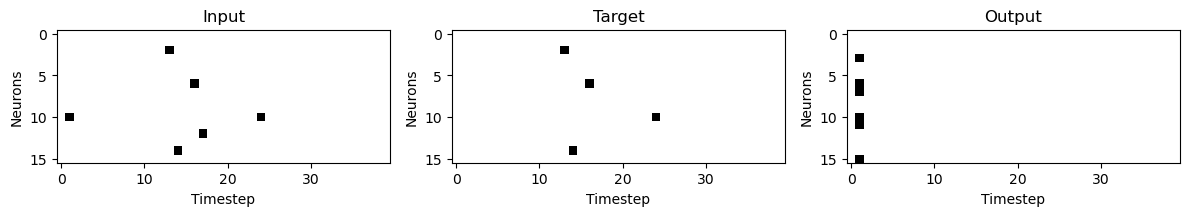

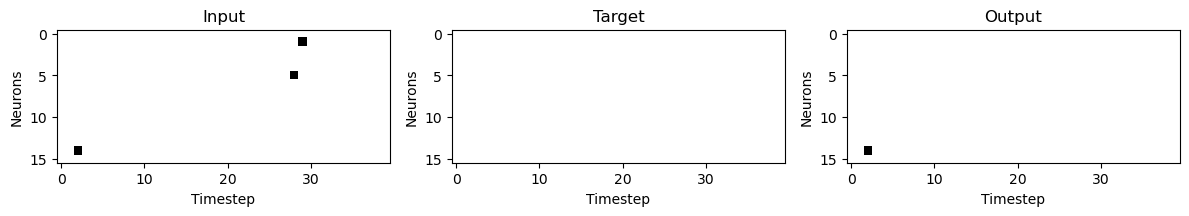

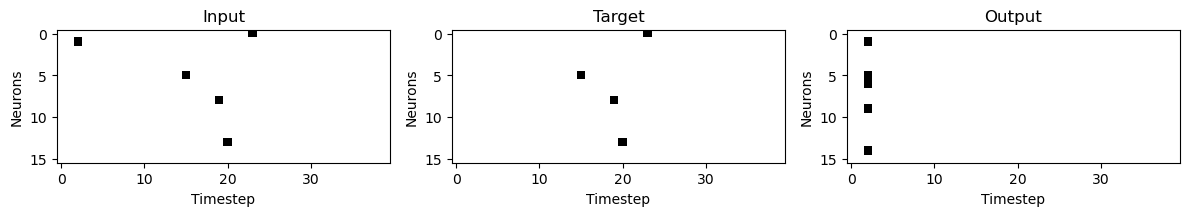

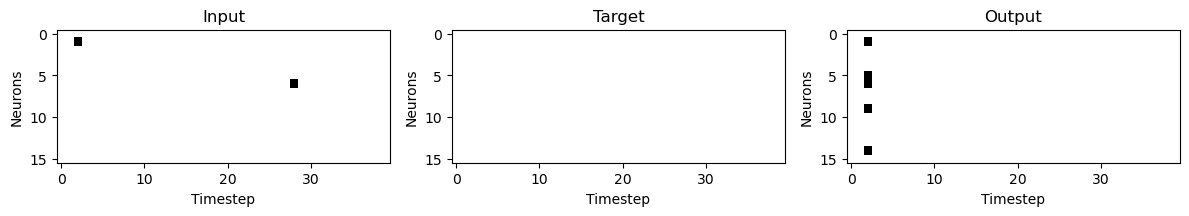

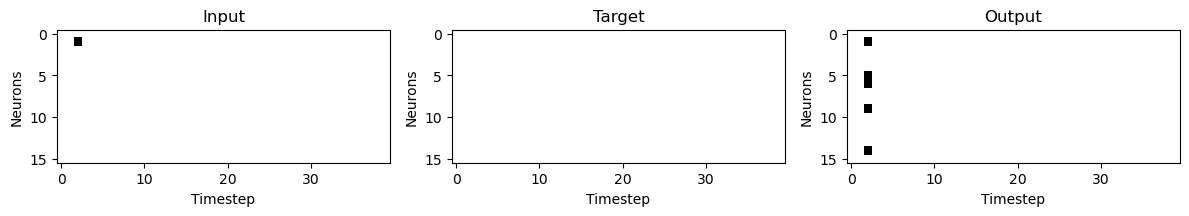

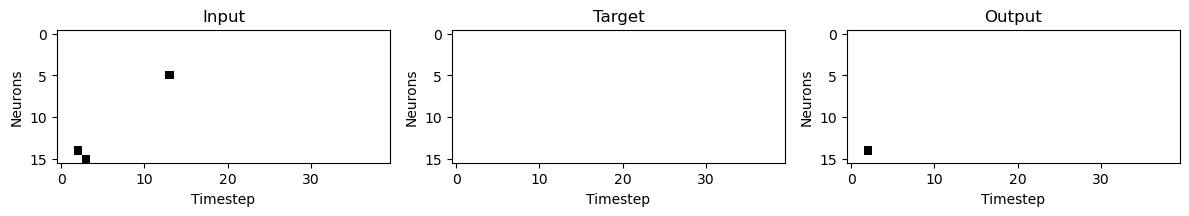

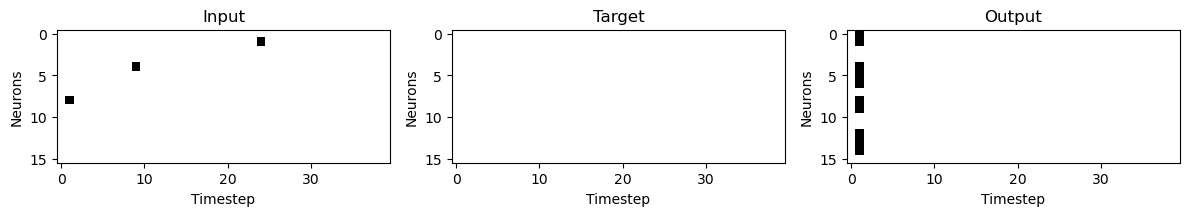

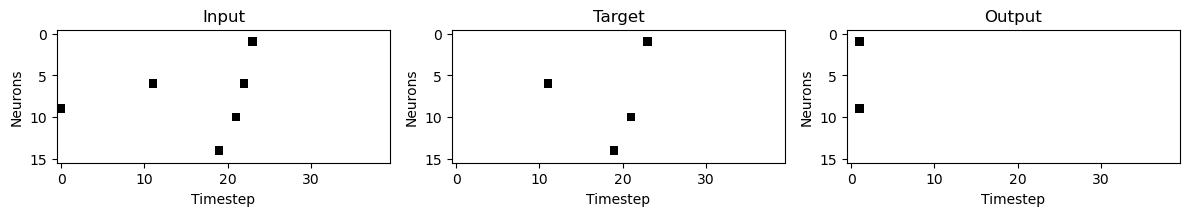

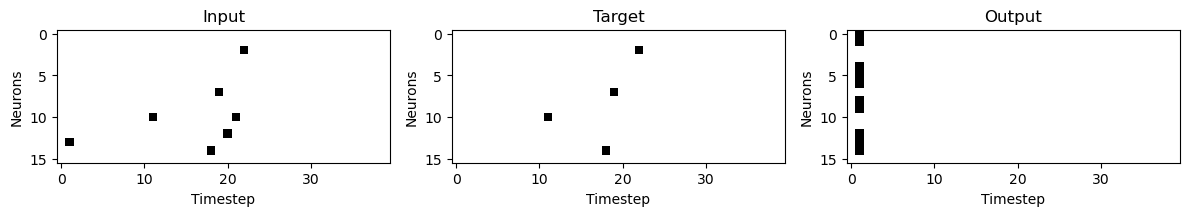

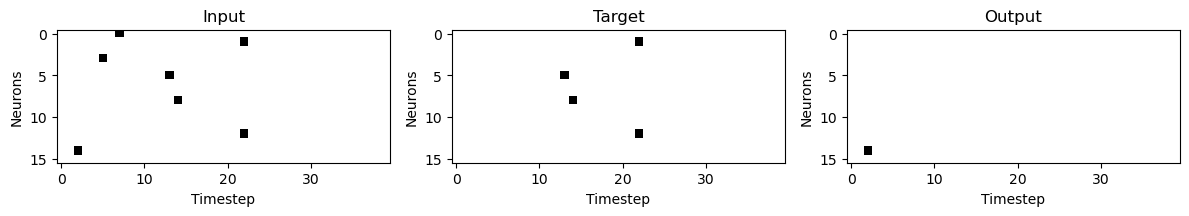

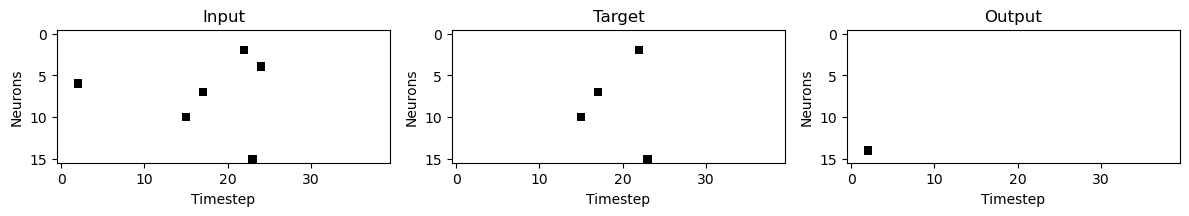

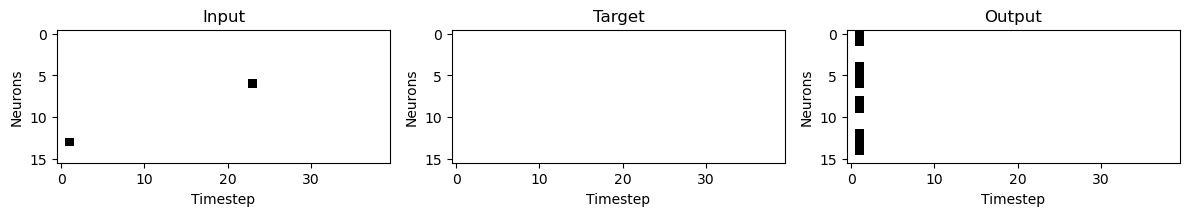

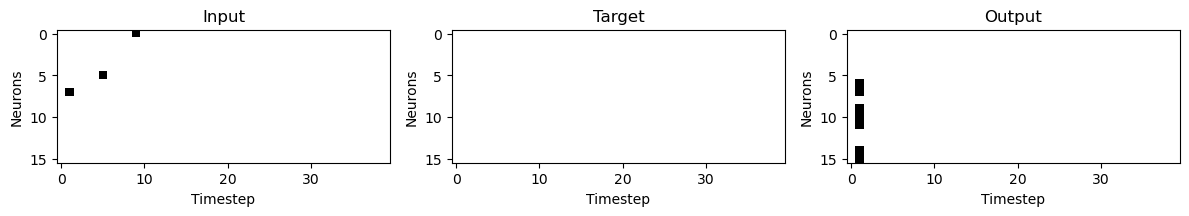

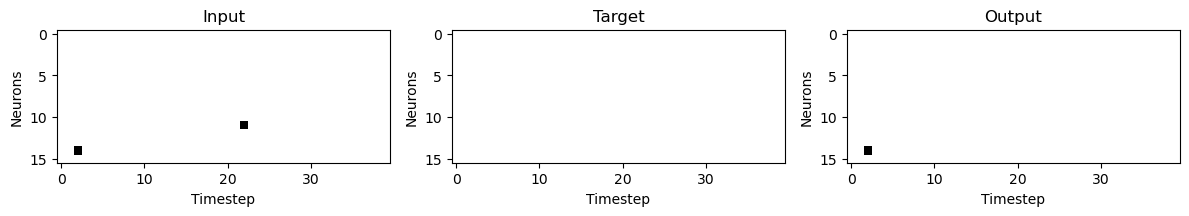

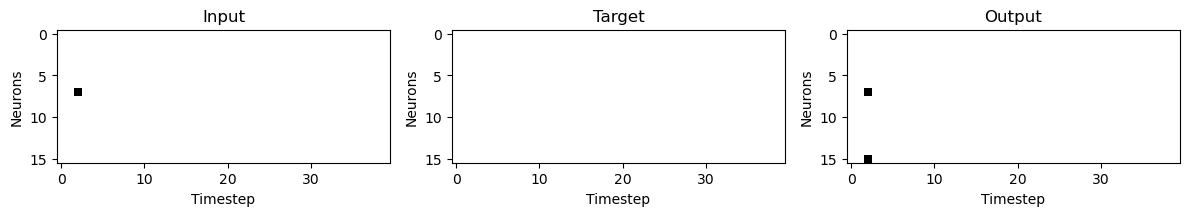

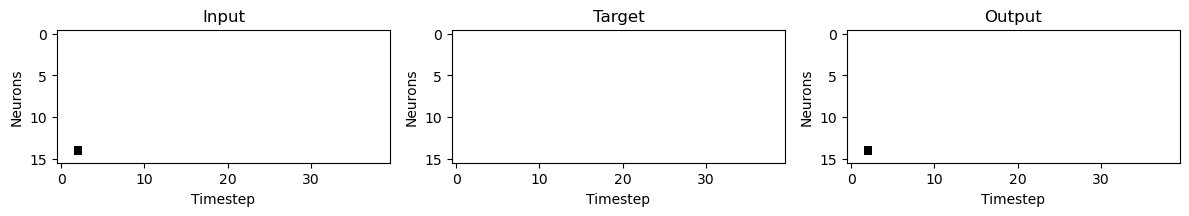

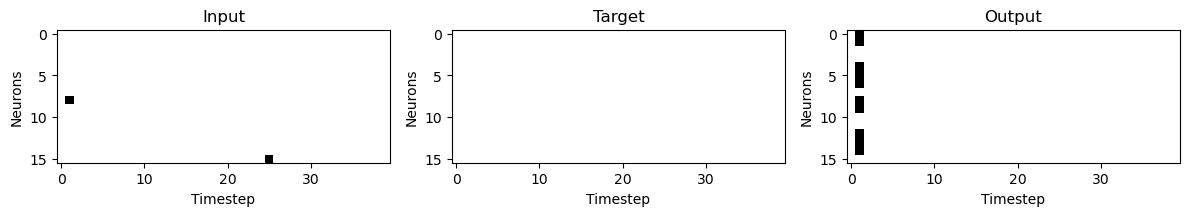

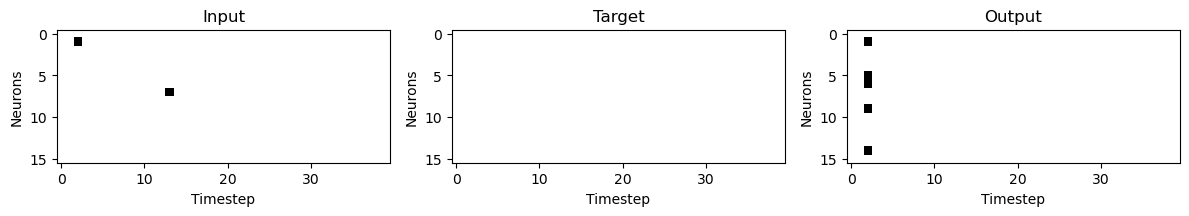

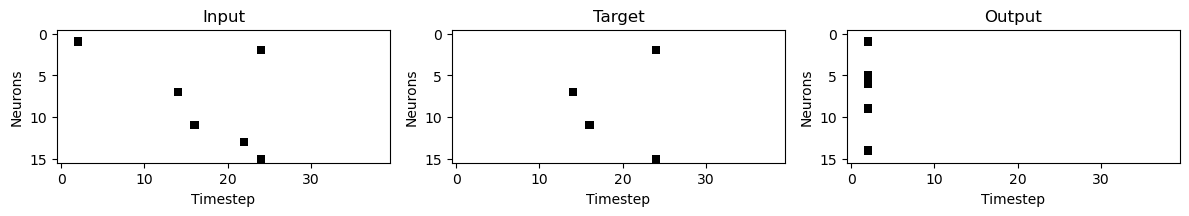

22 2112


In [240]:
counter = 0
counter_tgt = 0
sigmoid = nn.Sigmoid()
with torch.no_grad():
    for data, targets in val_loader:

    #print("data shape:", data.shape)
    #print("data[2]:", data[2])

    #print("\nTarget shape:", targets.shape)
    #print("Target[2]:", targets[2])

        spike_in = custom_spikegen(data, num_steps)
        spk_rec, mem_rec = net(spike_in)

    #print("\nmem_rec shape:", mem_rec.shape)

        targets = custom_spikegen(targets, num_steps, batch_size, True).type(torch.long)
    #print("New target shape:", targets.shape)
        predicted = sigmoid(mem_rec)
        predicted[predicted <  0.5] = 0
        predicted[predicted >= 0.5] = 1
    
        for i in range(batch_size):
            if torch.count_nonzero(targets[:,i]) != 0:
                counter_tgt += 1
            if torch.count_nonzero(predicted[:,i]) != 0:
                counter += 1
                plot_spiketrains([spike_in[:,i], targets[:,i], predicted[:,i]], ['Input','Target', 'Output'])

    '''
    spk_count = spk_rec.sum(dim=0)
    print("\nspk_count shape:", spk_count.shape)

    print("spk_count[2]:", spk_count[2])

    a = spk_count.view(batch_size, ps.NLAYERS*ps.NWIRES, -1)
    print("\na shape:", a.shape)
    print("a[2]:", a[2])

    _, b = a.max(2)
    print("\nb shape:", b.shape)
    print("b[2]:", b[2])
    
    c = b.view(batch_size, ps.NLAYERS, -1)
    print("\nc shape:", c.shape)
    print("c[2]:", c[2])

    new_target = targets.view(batch_size, -1)
    print("\nlinearised targets shape:", new_target.shape)
    print("linearised targtes[2]:", new_target[2])
    print("")
    
    break'''

print(counter, counter_tgt)